In [10]:
import pymc as pm
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

In [17]:
# observations
variant1_observations = np.array([0]*(618-257) + [1]*257)
variant2_observations = np.array([0]*(579-269) + [1]*269)
control_observations = np.array([0]*(321-165) + [1]*165)
np.random.shuffle(variant1_observations)
np.random.shuffle(variant2_observations)
np.random.shuffle(control_observations)

In [19]:
print control_observations.mean()
print variant1_observations.mean()
print variant2_observations.mean()

0.514018691589
0.415857605178
0.464594127807


In [20]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=control_observations, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=variant1_observations, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 3.2 sec

In [21]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

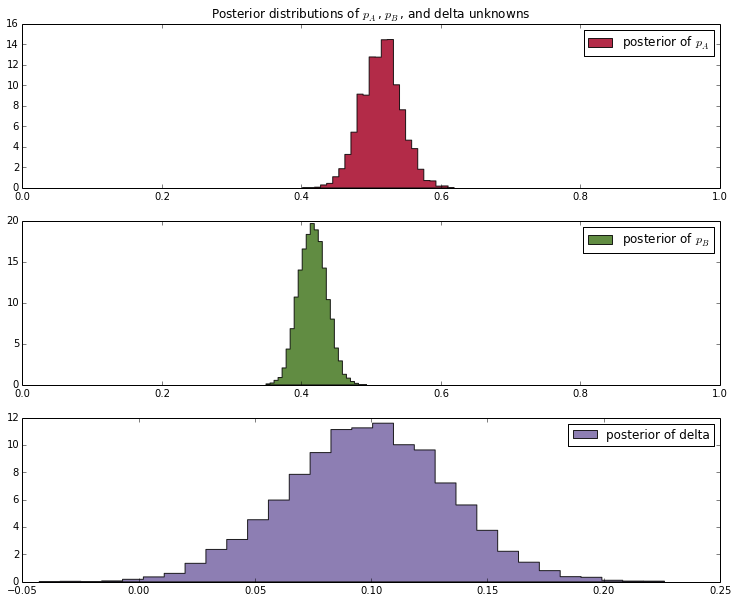

In [30]:
figsize(12.5, 10)

true_p_A = 0.514018691589
true_p_B = 0.415857605178

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, 1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, 1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
# plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
# plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
#            label="true delta (unknown)")
# plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [31]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print "Probability site A is WORSE than site B: %.3f" % \
    (delta_samples < 0).mean()

print "Probability site A is BETTER than site B: %.3f" % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.002
Probability site A is BETTER than site B: 0.998
